<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the database and installing the necessary libraries

In [148]:
!pip install yfinance seaborn ipywidgets

###  Importações necessárias

In [125]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import ipywidgets as widgets

# Estilo de visualização corrigido
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')


### Base de Dados Bitcoins

In [126]:
ticket = "BTC-USD"
dados = yf.download(ticket, start="2007-08-18", end="2025-08-18")

# Realizar o resampling para frequência mensal
dados_weekly = dados['Close'].resample('ME').last().dropna()
print(dados_weekly)

[*********************100%***********************]  1 of 1 completed

Ticker            BTC-USD
Date                     
2014-09-30     386.944000
2014-10-31     338.321014
2014-11-30     378.046997
2014-12-31     320.192993
2015-01-31     217.464005
...                   ...
2024-12-31   93429.203125
2025-01-31  102405.023438
2025-02-28   84373.007812
2025-03-31   82548.914062
2025-04-30   84830.742188

[128 rows x 1 columns]


### Random Walk com ruído

In [127]:
np.random.seed(42)
random_walk = np.cumsum(np.random.normal(0, 100, len(dados_weekly)))
plt.show()

In [128]:
# Criando DataFrame para armazenar os dados
dados_rw = pd.DataFrame({
    'Close': dados_weekly.values.squeeze(),  # Convertendo para 1D
    'Random Walk': random_walk
}, index=dados_weekly.index)
dados_rw['Close RW'] = dados_rw['Close'] + dados_rw['Random Walk']


### Autocorrelação e Estacionáriedade

Autocorrelações para os lags de 1 a 20:
Lag 1: 0.9753
Lag 2: 0.9461
Lag 3: 0.9155
Lag 4: 0.8960
Lag 5: 0.8720
Lag 6: 0.8554
Lag 7: 0.8362
Lag 8: 0.8149
Lag 9: 0.7797
Lag 10: 0.7416
Lag 11: 0.7057
Lag 12: 0.6577
Lag 13: 0.6127
Lag 14: 0.5592
Lag 15: 0.5111
Lag 16: 0.4800
Lag 17: 0.4586
Lag 18: 0.4448
Lag 19: 0.4383
Lag 20: 0.4386


<Figure size 1000x600 with 0 Axes>

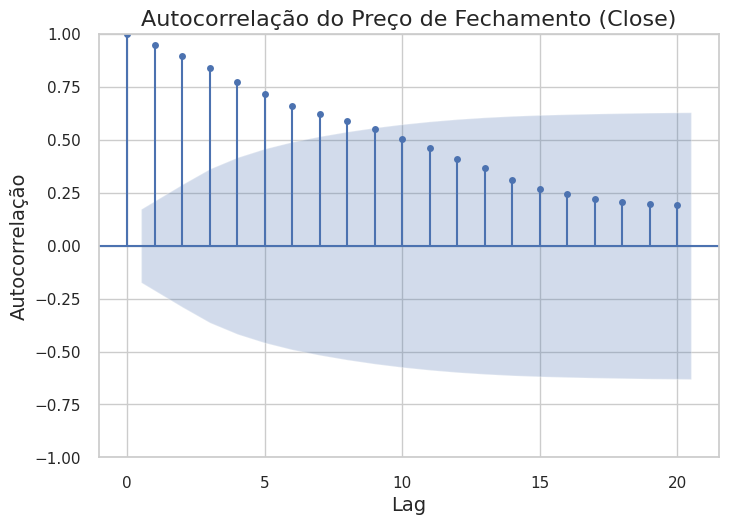

In [143]:


# Calcular a autocorrelação para diferentes lags
max_lag = 20
autocorr_values = [dados_rw['Close'].autocorr(lag=i) for i in range(1, max_lag+1)]

# Exibir as autocorrelações para os lags de 1 a max_lag
print(f"Autocorrelações para os lags de 1 a {max_lag}:")
for i, autocorr in enumerate(autocorr_values, start=1):
    print(f"Lag {i}: {autocorr:.4f}")

# Plotando a autocorrelação para diferentes lags com melhorias no gráfico
plt.figure(figsize=(10, 6))
plot_acf(dados_rw['Close'], lags=max_lag, alpha=0.05)
plt.title('Autocorrelação do Preço de Fechamento (Close)', fontsize=16)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('Autocorrelação', fontsize=14)
plt.grid(True)
plt.show()

In [144]:
# Cálculos das métricas
media_rw = np.mean(dados_rw['Random Walk'])
desvio_padrao_rw = np.std(dados_rw['Random Walk'])

# Calculando MSE e MAPE
mse_rw = mean_squared_error(dados_rw['Close'], dados_rw['Close RW'])
mape_rw = mean_absolute_percentage_error(dados_rw['Close'], dados_rw['Close RW'])

# Teste de Estacionaridade (ADF)
def test_stationarity(series):
    result = adfuller(series)
    return result[1]  # Retorna o p-value do teste

p_value_rw = test_stationarity(dados_rw['Random Walk'])
stationarity_result = "Estacionária" if p_value_rw < 0.05 else "Não Estacionária"

# Exibindo as métricas
print(f"Média do Random Walk: {media_rw:.2f}")
print(f"Desvio Padrão do Random Walk: {desvio_padrao_rw:.2f}")
print(f"MSE do Random Walk: {mse_rw:.2f}")
print(f"MAPE do Random Walk: {mape_rw:.2f}")
print(f"Teste de Estacionaridade: {stationarity_result} (p-value: {p_value_rw:.4f})")

Média do Random Walk: -734.46
Desvio Padrão do Random Walk: 453.00
MSE do Random Walk: 744634.08
MAPE do Random Walk: 0.24
Teste de Estacionaridade: Não Estacionária (p-value: 0.3760)


In [147]:
# Função para plotar as métricas com Plotly
def plot_metrics_plotly():
    metrics = {
        'Média': media_rw,
        'Desvio Padrão': desvio_padrao_rw,
        'MSE': mse_rw,
        'MAPE': mape_rw
    }

    # Criando o gráfico com Plotly
    fig = go.Figure()

    # Adicionando as métricas como linhas e marcadores
    fig.add_trace(go.Scatter(
        x=list(metrics.keys()),
        y=list(metrics.values()),
        mode='lines+markers',
        line=dict(color='blue', width=3),
        marker=dict(size=10, color='red'),
        name="Métrica"
    ))

    # Atualizando o layout do gráfico
    fig.update_layout(
        title='Métricas do Random Walk',
        xaxis_title='Métrica',
        yaxis_title='Valor',
        template='plotly_dark',
        showlegend=False
    )

    # Adicionando as anotações de valores no gráfico
    for i, (metric, value) in enumerate(metrics.items()):
        fig.add_annotation(
            x=metric,
            y=value + 5,  # Distância para as anotações não se sobreporem aos pontos
            text=f'{value:.2f}',
            showarrow=False,
            font=dict(size=12, color='black')
        )

    # Exibindo o gráfico interativo
    fig.show()

# Chama a função para gerar o gráfico
plot_metrics_plotly()

In [155]:
def generate_random_walk_2d_from_bitcoin(prices, std=100):
    returns = prices.pct_change().dropna()
    x_walk = np.cumsum(np.random.normal(loc=returns.mean(), scale=returns.std(), size=len(returns)))
    y_walk = np.cumsum(np.random.normal(loc=returns.mean(), scale=returns.std(), size=len(returns)))

    return x_walk, y_walk
ticket = "BTC-USD"
dados = yf.download(ticket, start="2007-08-18", end="2025-08-18")
dados_weekly = dados['Close'].resample('ME').last().dropna()
x_walk, y_walk = generate_random_walk_2d_from_bitcoin(dados_weekly)


# Usando o Plotly para gráfico interativo
def plot_random_walk_2d_plotly(x_walk, y_walk):
    # Criando o gráfico com Plotly
    fig = go.Figure()

    # Adicionando o passeio aleatório 2D como linha
    fig.add_trace(go.Scatter(
        x=x_walk,
        y=y_walk,
        mode='lines+markers',
        line=dict(color='blue', width=3),
        marker=dict(size=5, color='red'),
        name="Passeio Aleatório 2D"
    ))

    # Atualizando o layout do gráfico
    fig.update_layout(
        title='Passeio Aleatório 2D - Bitcoin',
        xaxis_title='Movimento Aleatório X',
        yaxis_title='Movimento Aleatório Y',
        template='seaborn',
        showlegend=True
    )

    # Exibindo o gráfico interativo
    fig.show()

# Plotando o passeio aleatório 2D de forma interativa
plot_random_walk_2d_plotly(x_walk, y_walk)


[*********************100%***********************]  1 of 1 completed
